In [1]:
import argparse
import pathlib
import pickle
import h5py
import random
import json
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from python_speech_features import mel2hz
from scipy import interpolate
from python_speech_features import hz2mel, mel2hz
import torch

%matplotlib inline

In [2]:
lstm_path  = '/home/yangwenhao/project/lstm_speaker_verification'
check_path = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint'
root_path  = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/gradient'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
cam_method = 'integrad2' #   fullgrad grad_cam_pp integrad layer_cam
model_path = 'ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_chn32_wd5e5_varesmix8/arcsoft_sgd_rop/vox2/wave_fb80_dist/123456'
train_set = 'vox2'
epoch = 19

input_path = root_path + '/ThinResNet34/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/vox2_dev4'

In [78]:
cam_method = 'integrad2' #   fullgrad grad_cam_pp integrad layer_cam
model_path = 'ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_wd5e5_varesmix8/arcsoft_sgd_rop/aishell2/wave_fb80_dist2/123456'
train_set = 'aishell2'
epoch = 29

input_path = root_path + '/ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_wd5e5_varesmix8/arcsoft_sgd_rop/aishell2/wave_fb80_dist2/123456/aishell2_dev4'

In [4]:
from TrainAndTest.common_func import create_model, load_model_args, args_model, args_parse
import torch

# check_yaml = '../../../Data/checkpoint/ThinResNet34/Mean_batch128_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/vox1/wave_fb80_dist2/123456/model.2023.06.06.yaml'

check_yaml = check_path + '/{}/model.2023.06.29.yaml'.format(model_path)

model_kwargs = load_model_args(check_yaml)

model = model_kwargs['embedding_model']
if 'classifier' in model_kwargs:
    model.classifier = model_kwargs['classifier']
    
trans = model.input_mask[0]
del model

In [79]:
extract_path = root_path + '/{}/epoch_{}_var/{}_soft'.format(model_path, epoch, cam_method)
# input_path = root_path + '/{}/{}_dev4'.format(model_path, train_set)

# Training options
feat_dim = 80
samples = 23976
acoustic_feature = 'fbank' # choices=['fbank', 'spectrogram', 'mfcc'],
seed = 123456

random.seed(seed)
np.random.seed(seed)

In [80]:
uid2spk = {}
with open(lstm_path + '/data/{}/dev/utt2spk'.format(train_set), 'r') as f:
    for l in f.readlines():
        uid, sid = l.split()
        # if uid in some_data:
        uid2spk[uid] = sid
    
sid2gender, uid2gender = {}, {}
if os.path.exists(lstm_path + '/data/{}/dev/spk2gender'.format(train_set)):
    with open(lstm_path + '/data/{}/dev/spk2gender'.format(train_set), 'r') as f:
        for l in f.readlines():
            sid, gender = l.split()
            sid2gender[sid] = gender
            
    for uid in uid2spk:
        this_sid = uid2spk[uid]
        uid2gender[uid] = sid2gender[this_sid] if this_sid in sid2gender else 'null'

sid2age, uid2age = {}, {}
if os.path.exists(lstm_path + '/data/{}/dev/spk2age'.format(train_set)):
    with open(lstm_path + '/data/{}/dev/spk2age'.format(train_set), 'r') as f:
        for l in f.readlines():
            sid, age = l.split()
            sid2age[sid] = age
            
    for uid in uid2spk:
        this_sid = uid2spk[uid]
        uid2age[uid] = sid2age[this_sid] if this_sid in sid2age else 'null'

In [81]:
def read_hdf5(reader, key):
    with h5py.File(reader, 'r') as r:
        data_flat = r.get(key)[:]
        return data_flat

In [82]:
# load selected input uids
data_reader = input_path + '/data.h5py'
assert os.path.exists(data_reader), print(data_reader)

uid_reader = input_path + '/uid_idx.json'
assert os.path.exists(uid_reader)
with open(uid_reader, 'r') as f:
    uididx = json.load(f)
    
some_data = set([uid for uid,idx in uididx])
print("Length of data: ", len(some_data))

Length of data:  7804


In [9]:
grad_reader = extract_path + '/grad.h5py'
assert os.path.exists(grad_reader), print(grad_reader)

### 1. Input Accustic features

In [12]:
input_std_m  = np.zeros((feat_dim))
input_mean_m = np.zeros((feat_dim))
males = 0

input_std_f  = np.zeros((feat_dim))
input_mean_f = np.zeros((feat_dim))
females = 0

for uid in tqdm(some_data, ncols=50):
    gender = uid2gender[uid]
    data = read_hdf5(data_reader, uid)
    the_data = trans(torch.tensor(data).reshape(1, 1, -1).float())
    if gender == 'm':
        input_mean_m += the_data[0].mean(axis=0).numpy()
        input_std_m  += the_data[0].std(axis=0).numpy()
        males += 1
    elif gender == 'f':
        input_mean_f += the_data[0].mean(axis=0).numpy()
        input_std_f  += the_data[0].std(axis=0).numpy()
        females += 1
        
input_std_m /= males
input_mean_m /= males

input_std_f /= females
input_mean_f /= females

100%|█████████| 7804/7804 [10:24<00:00, 12.50it/s]


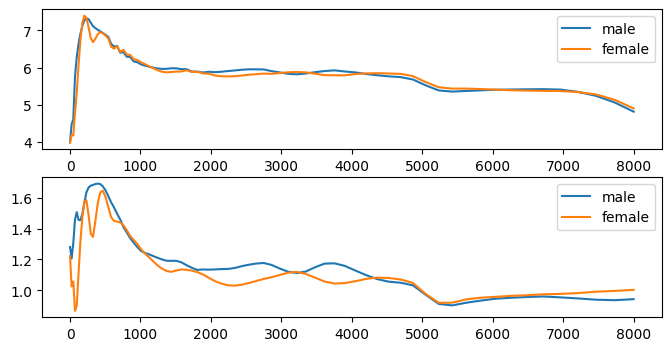

In [13]:
plt.figure(figsize=(8, 4))

# x = np.linspace(0, 8000, 161)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)

plt.subplot(2,1,1)
plt.plot(x, input_mean_m)
plt.plot(x, input_mean_f)

plt.legend(['male', 'female'])

plt.subplot(2, 1, 2)
plt.plot(x, input_std_m)
plt.plot(x, input_std_f)
plt.legend(['male', 'female'])

plt.savefig('imgs/%s_%s_input.png'%(train_set, cam_method), bbox_inches='tight')

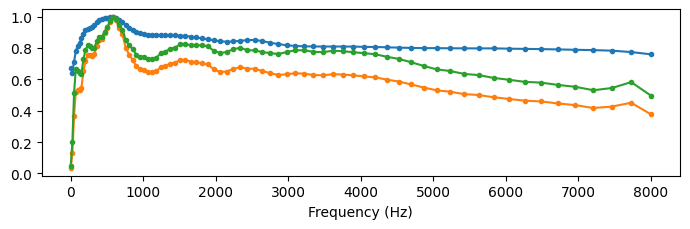

In [17]:
pdf = PdfPages('imgs/weights/input.pdf')
plt.figure(figsize=(7, 2.4))

y1 = input_std
y1 = y1 / y1.max()
# the_y1 = (y - y.min()) / (y.max() - y.min() + 1e-6)
# the_y1 = the_y1/the_y1.sum()
plt.plot(x, y1, marker='.')

y2 = sm_std
y2 = y2 / y2.max()
# the_y2 = (y - y.min()) / (y.max()-y.min() + 1e-6)
# the_y2 = the_y2 / the_y2.sum()

plt.plot(x, y2, marker='.')

plt.plot(x, y2/y1, marker='.')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

pdf.savefig()
pdf.close()

In [ ]:
m_mean, m_min, m_max = [], [], []
f_mean, f_min, f_max = [], [], []

males   = 0
females = 0

for uid in tqdm(some_data, ncols=50):
    gender = uid2gender[uid]
    age = uid2age[uid]
    
    data = read_hdf5(data_reader, uid)
    # the_data = tensor(data).float()
    pitch = F.detect_pitch_frequency(torch.tensor(data), 16000)
    if age in ['B']:
        if gender == 'm':
            m_mean.append(pitch.mean())
            m_min.append(pitch.min())
            m_max.append(pitch.max())
            males += 1
            
        elif gender == 'f':
            f_mean.append(pitch.mean())
            f_min.append(pitch.min())
            f_max.append(pitch.max())
            females += 1

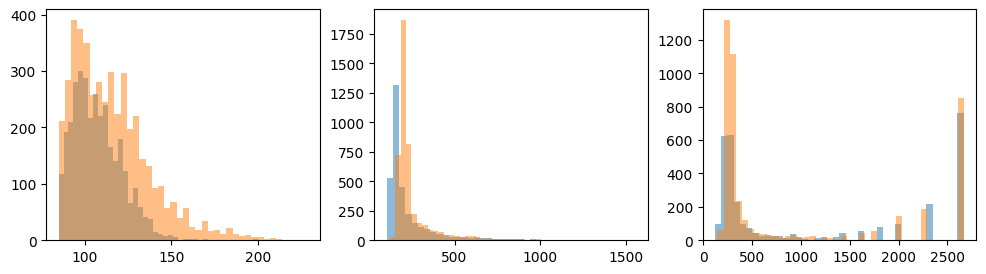

In [77]:
plt.figure(figsize=(12, 3))

plt.subplot(1,3,1)
_ = plt.hist(m_min,bins=40,alpha=0.5)
_ = plt.hist(f_min,bins=40,alpha=0.5)

plt.subplot(1,3,2)
_ = plt.hist(m_mean,bins=40,alpha=0.5)
_ = plt.hist(f_mean,bins=40,alpha=0.5)

plt.subplot(1,3,3)
_ = plt.hist(m_max,bins=40,alpha=0.5)
_ = plt.hist(f_max,bins=40,alpha=0.5)

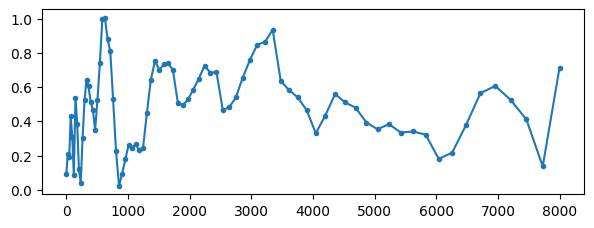

In [138]:
plt.figure(figsize=(7, 2.4))

plt.plot(x, (y2)/(y1), marker='.')

/home/yangwenhao/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


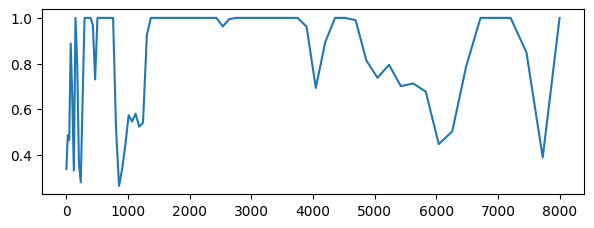

In [159]:
plt.figure(figsize=(7, 2.4))
w = torch.tensor(4*(y2)/(y1) - 2)
y = torch.nn.functional.sigmoid(w)
# 
beta = y.mean()
y = y.clamp_max(beta)/beta
plt.plot(x, y/y.max())

In [157]:
y.mean()

tensor(0.4916, dtype=torch.float64)

### 2. Saliency Mappings

In [14]:
def plot_cam_weight(cam_method, epoch=19, norm='none', time_norm='mean'):
    extract_path = root_path + '/{}/epoch_{}_var/{}_soft'.format(model_path, epoch, cam_method)
    grad_reader = extract_path + '/grad.h5py'
    assert os.path.exists(grad_reader), print(grad_reader)
    
    sm_mean = np.zeros((feat_dim))
    for uid in tqdm(some_data, ncols=50):
        gender = uid2gender[uid]
        data = read_hdf5(grad_reader, uid)
        if cam_method in ['mask', 'igos']:
            data = 1 - data
        
        if norm == 'abs':
            data = np.abs(data)
        elif norm == 'relu':
            data = np.clip(data, a_min=0, a_max=None)
        
        if time_norm == 'mean':
            sm_mean += data.mean(axis=0)
        elif time_norm == 'max':
            sm_mean += data.max(axis=0)

    sm_mean /= len(some_data)
    
    the_y = (sm_mean - sm_mean.min()) / (sm_mean.max() - sm_mean.min() + 1e-6)
    the_y = the_y/the_y.sum()
    
    plt.plot(x, the_y, marker='.')

In [15]:
cam_method = 'integrad2' #   fullgrad grad_cam_pp integrad layer_cam exptgrad igos
# model_path = 'ThinResNet34/Mean_batch128_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/vox1/wave_fb80_dist2/123456'
# train_set = 'vox2'
# epoch = 19

extract_path = root_path + '/{}/epoch_{}_var/{}_soft'.format(model_path, epoch, cam_method)
grad_reader = extract_path + '/grad.h5py'
assert os.path.exists(grad_reader), print(grad_reader)

In [84]:
sm_std_f  = np.zeros((feat_dim))
sm_mean_f = np.zeros((feat_dim))
males   = 0
females = 0

sm_std_m  = np.zeros((feat_dim))
sm_mean_m = np.zeros((feat_dim))

for uid in tqdm(some_data, ncols=50):
    gender = uid2gender[uid]
    age = uid2age[uid]
    
    data = read_hdf5(grad_reader, uid)
    # data = np.clip(data, a_min=0, a_max=None)
    # data = np.abs(data)
    # break
    if age in ['B']:
        if gender == 'm':
            sm_mean_m += data.mean(axis=0)
            sm_std_m  += data.std(axis=0)
            males += 1
            
        elif gender == 'f':
            sm_mean_f += data.mean(axis=0)
            sm_std_f  += data.std(axis=0)
            females += 1
        
    # sm_mean += data.mean(axis=0)
    # sm_std  += data.std(axis=0)
        
# sm_std /= len(some_data)
# sm_mean /= len(some_data)
sm_std_m /= males
sm_mean_m /= males

sm_std_f /= females
sm_mean_f /= females

100%|███████| 7804/7804 [00:07<00:00, 1014.48it/s]


In [87]:
from scipy.ndimage import gaussian_filter1d

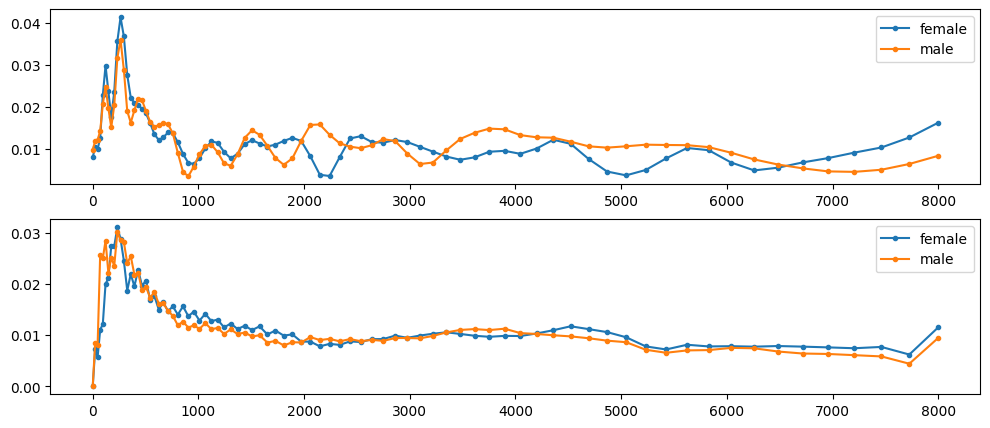

In [88]:
plt.figure(figsize=(12, 5))

# x = np.linspace(0, 8000, 161)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)

plt.subplot(2,1,1)
y = sm_mean_f
the_y = (y - y.min()) / (y.max()-y.min() + 1e-6)
the_y = the_y / the_y.sum()
the_y = gaussian_filter1d(the_y, 1)
plt.plot(x, the_y, marker='.')

y = sm_mean_m
the_y = (y - y.min()) / (y.max()-y.min() + 1e-6)
the_y = the_y / the_y.sum()
the_y = gaussian_filter1d(the_y, 1)

plt.plot(x, the_y, marker='.')

plt.legend(['female', 'male'])

plt.subplot(2, 1, 2)
y = sm_std_f
the_y = (y - y.min()) / (y.max()-y.min() + 1e-6)
the_y = the_y / the_y.sum()
plt.plot(x, the_y, marker='.')

y = sm_std_m
the_y = (y - y.min()) / (y.max()-y.min() + 1e-6)
the_y = the_y / the_y.sum()
plt.plot(x, the_y, marker='.')

plt.legend(['female', 'male'])
plt.savefig('imgs/%s_%s_gender.png'%(train_set, cam_method), bbox_inches='tight')

# male 的关注 峰 明显低于 female，和语音信号的共振峰性别差异趋势相同

In [22]:
import torchaudio.functional as F

In [23]:
data = read_hdf5(data_reader, uid)

In [24]:
data.shape

(51680,)

In [28]:
pitch_feature = F.compute_kaldi_pitch(torch.tensor(data), 16000)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

In [30]:
pitch2 = F.detect_pitch_frequency(torch.tensor(data), 16000)

In [ ]:
pitch2

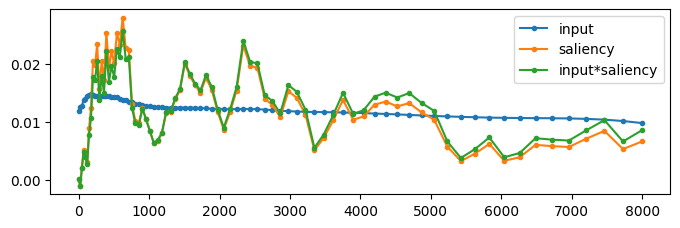

In [30]:
plt.figure(figsize=(8, 2.4))

# x = np.linspace(0, 8000, 161)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)
y3 = []
for y in [input_std, sm_mean]:
    the_y = y #(y - y.min()) / (y.max()-y.min() + 1e-6)
    the_y = the_y/the_y.sum()
    y3.append(the_y)
    plt.plot(x, the_y, marker='.')
    
the_y = y3[1]/y3[0]
plt.plot(x, the_y/the_y.sum(), marker='.')

plt.legend(['input', 'saliency'])
plt.savefig('imgs/%s_%s_input_cam.png'%(train_set, cam_method), bbox_inches='tight')

In [ ]:
# x = np.linspace(0, 8000, 161)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)

plt.figure(figsize=(14, 12))

weight_norm = 'none'
cam_metholds = ['gradient', 'integrad','integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
for i,cam_method in enumerate(cam_metholds):
    plt.subplot(5, 2, i+1)
    
    plot_cam_weight(cam_method, epoch=19, norm=weight_norm)
    plt.legend([cam_method])
    
plt.savefig('imgs/weights/%s_%s.png'%(train_set, weight_norm), bbox_inches='tight')
# plt.legend(cam_metholds)

In [ ]:
# x = np.linspace(0, 8000, 161)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)

plt.figure(figsize=(14, 12))
cam_metholds = ['gradient', 'integrad','integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
for i,cam_method in enumerate(cam_metholds):
    plt.subplot(5, 2, i+1)
    plot_cam_weight(cam_method, epoch=26, norm='relu')
    plt.legend([cam_method])

plt.savefig('imgs/weights_relu/%s_all.png'%(train_set), bbox_inches='tight')
# plt.legend(cam_metholds)

100%|███████| 4844/4844 [00:02<00:00, 1781.33it/s]


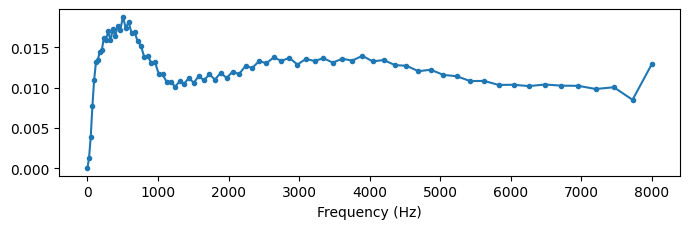

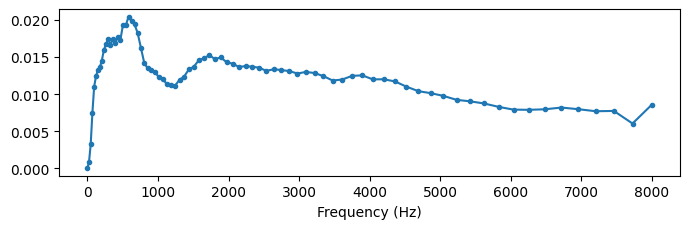

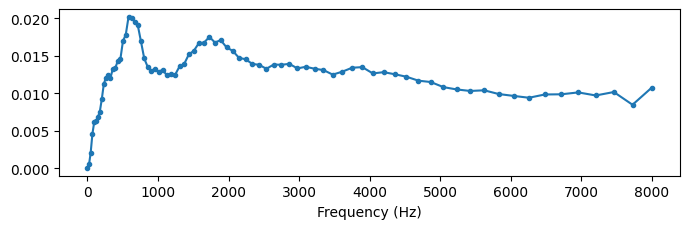

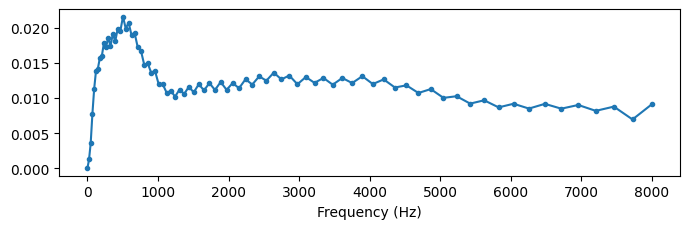

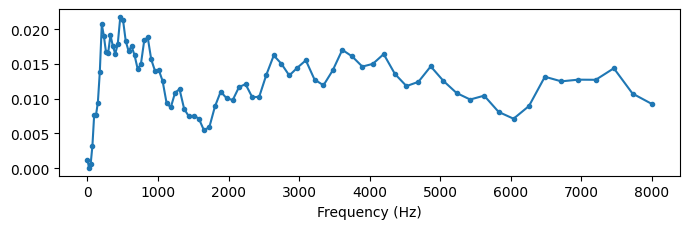

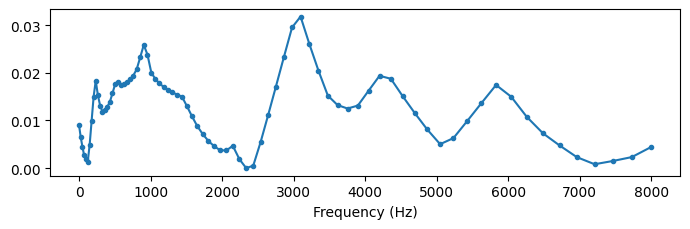

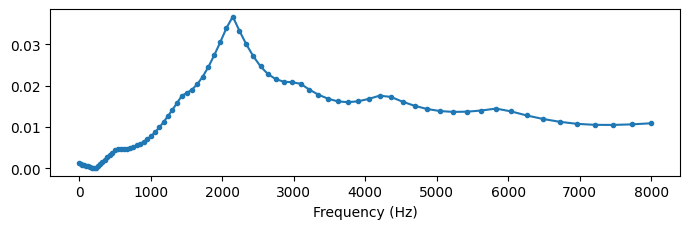

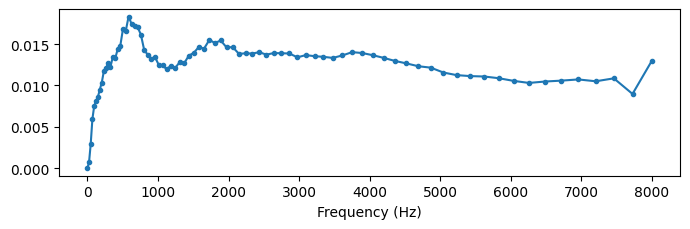

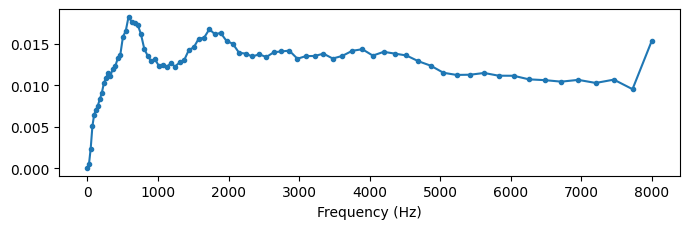

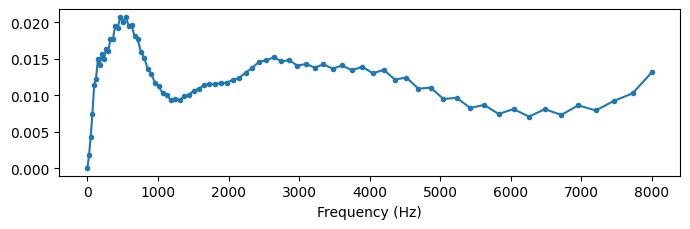

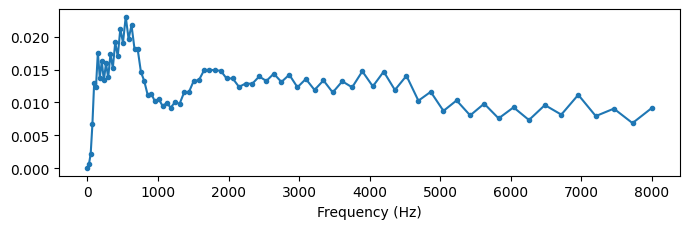

In [118]:
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)

cam_metholds = ['gradient', 'integrad','integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
# cam_metholds = ['mask', 'igos']

for i,cam_method in enumerate(cam_metholds):
    # plt.subplot(5, 2, i+1)
    pdf = PdfPages('imgs/weights_relu_max/%s.%s.pdf'%(train_set, cam_method))
    plt.figure(figsize=(7, 2.4))
    plot_cam_weight(cam_method, epoch=26, norm='relu', time_norm='max')
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()

    pdf.savefig()
    pdf.close()
    # plt.legend([cam_method])
    # plt.savefig('imgs/weights_relu/%s_all.png'%(train_set), bbox_inches='tight')

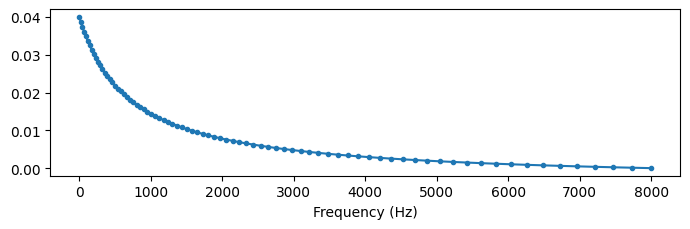

In [111]:
pdf = PdfPages('imgs/weights/mel.pdf')
plt.figure(figsize=(7, 2.4))

y = 2595 / (np.log(10)*(700 + x ))
the_y = (y - y.min()) / (y.max() - y.min() + 1e-6)
the_y = the_y/the_y.sum()
    
plt.plot(x, the_y, marker='.')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

pdf.savefig()
pdf.close()